http://localhost:5173/stream_plot?video_id=9KENE2wOphQ

In [1]:
# DIRECTORY SET
import os
import sys
from pathlib import Path
base_dir=Path(os.getcwd()).parent
# os.chdir(os.path.join(base_dir, 'serverproject'))
os.chdir(base_dir)
print(os.getcwd())

# Load dotenv
import dotenv
dotenv.load_dotenv()

# DJANGO SETUP
import django
sys.path.append(os.path.abspath(''))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "serverproject.settings")
django.setup()

# Import async modules
import asyncio
from asgiref.sync import sync_to_async

# Import display modules
from IPython.display import display, Markdown

# Import other modules
import faiss

# import reloading
from importlib import reload

d:\DestinyFolder\DestinyRecaps\DestinyRecapsApi\serverproject


In [2]:
%load_ext autoreload
%autoreload 2

from destinyapp.models import StreamRecapData, FastRecapData

from core import services
from core import utils
from core import controller

In [3]:
async def fetch_embedding(chunk):
    model="text-embedding-3-large"
    fails=0
    while fails<5:
        try:
            return await utils.async_openai_client.embeddings.create(input=chunk, model=model)
        except Exception as e:
            fails+=1
            print("Emedding Fail Retrying:",e)
            await asyncio.sleep(10+(fails*2))
    return None

In [7]:
video_id="9KENE2wOphQ"
video_id="9KENE2wOphQ_no_recap"
data_grabbber=await sync_to_async(FastRecapData.objects.filter)(video_id=video_id)
fast_recap_data=await sync_to_async(data_grabbber.first)()

In [9]:
all_embeddings=[]

tasks=[]

for segment in fast_recap_data.plot_object["segments"]:
    tasks.append(fetch_embedding(segment["recap"]))

all_embeddings=await asyncio.gather(*tasks)

In [16]:
# pull .data[0].embedding into a list
all_embeddings_data=[raw_embedding_data.data[0].embedding for raw_embedding_data in all_embeddings]

In [10]:
# calculate distance between each embedding and all the other embeddings
import numpy as np
distances_matrix=np.zeros((len(all_embeddings),len(all_embeddings)))

for i in range(len(all_embeddings)):
    for j in range(len(all_embeddings)):
        e1=np.array(all_embeddings[i].data[0].embedding)
        e2=np.array(all_embeddings[j].data[0].embedding)
        distances_matrix[i][j]=np.linalg.norm(e1-e2)

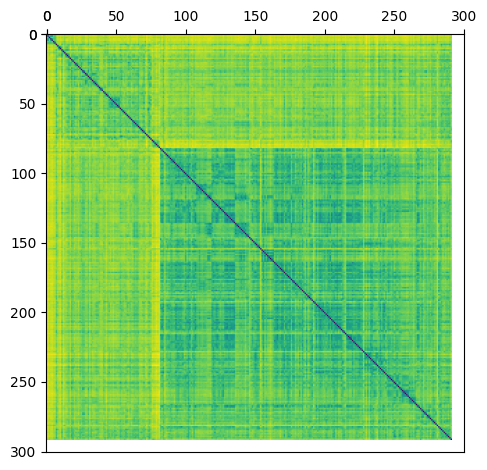

In [11]:
import matplotlib.pyplot as plt

# Assuming you've already created your distances_matrix
plt.imshow(distances_matrix)

# Get the current axes
ax = plt.gca()

# Move x-axis ticks and label to the top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# Ensure the '0' tick is shown on both axes
ax.set_xticks([0] + list(ax.get_xticks()[1:]))
ax.set_yticks([0] + list(ax.get_yticks()[1:]))

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
from sklearn.cluster import KMeans

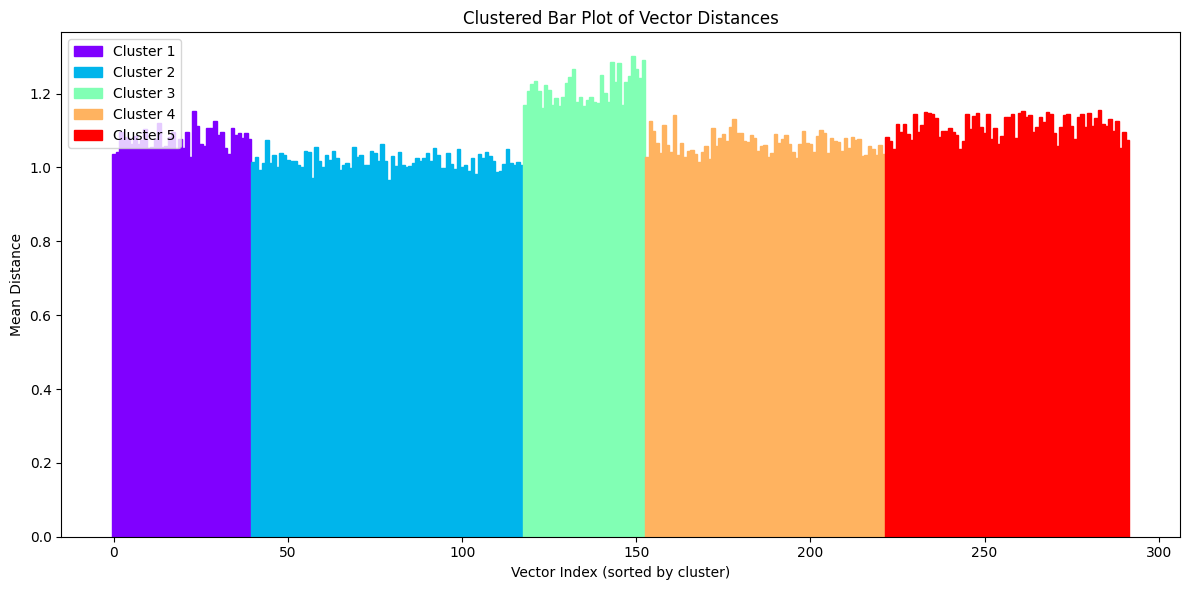

In [13]:
k = 5  # Number of clusters, adjust as needed
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(distances_matrix)

# 2. Calculate mean distances for each vector
mean_distances = np.mean(distances_matrix, axis=1)

# 3. Sort by cluster
sorted_indices = np.argsort(cluster_labels)
sorted_distances = mean_distances[sorted_indices]
sorted_labels = cluster_labels[sorted_indices]

# 4. Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(sorted_distances)), sorted_distances, width=1.0)

# 5. Color the bars according to their cluster
colors = plt.cm.rainbow(np.linspace(0, 1, k))
for i, bar in enumerate(bars):
    bar.set_color(colors[sorted_labels[i]])

# 6. Customize the plot
plt.xlabel('Vector Index (sorted by cluster)')
plt.ylabel('Mean Distance')
plt.title('Clustered Bar Plot of Vector Distances')

# Add a color legend
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(k)]
plt.legend(handles, [f'Cluster {i+1}' for i in range(k)])

plt.tight_layout()
plt.show()

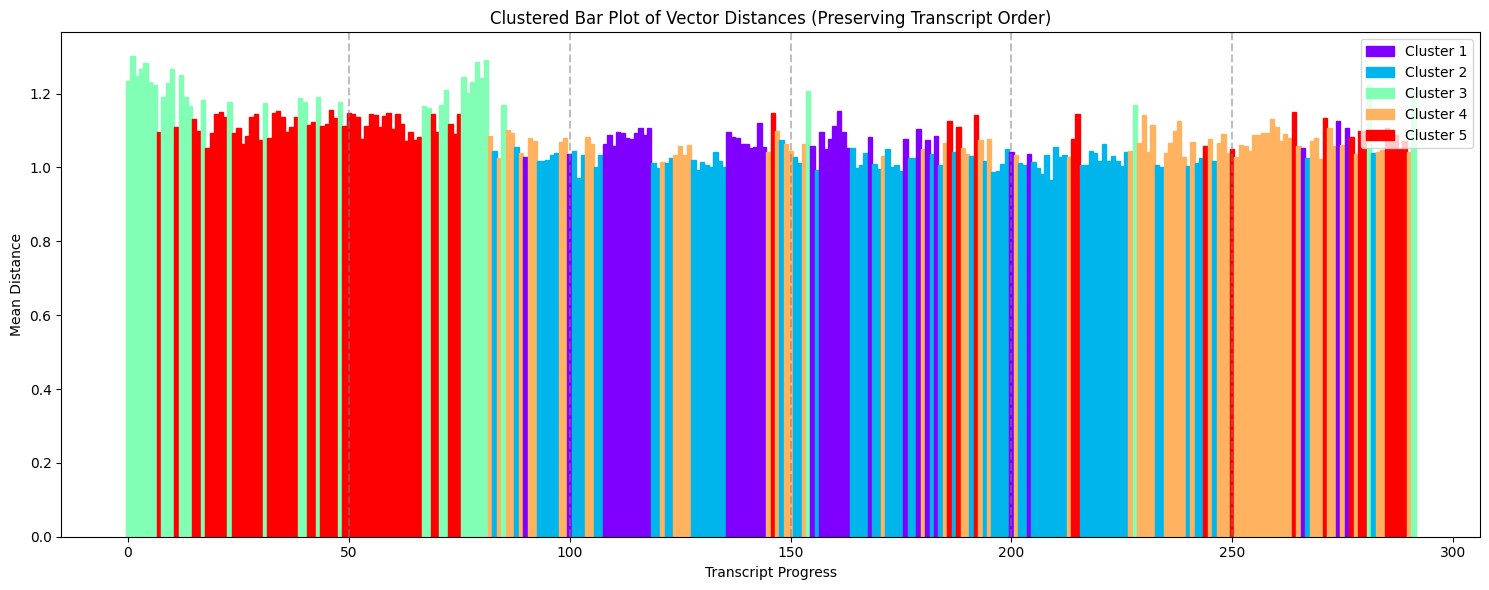

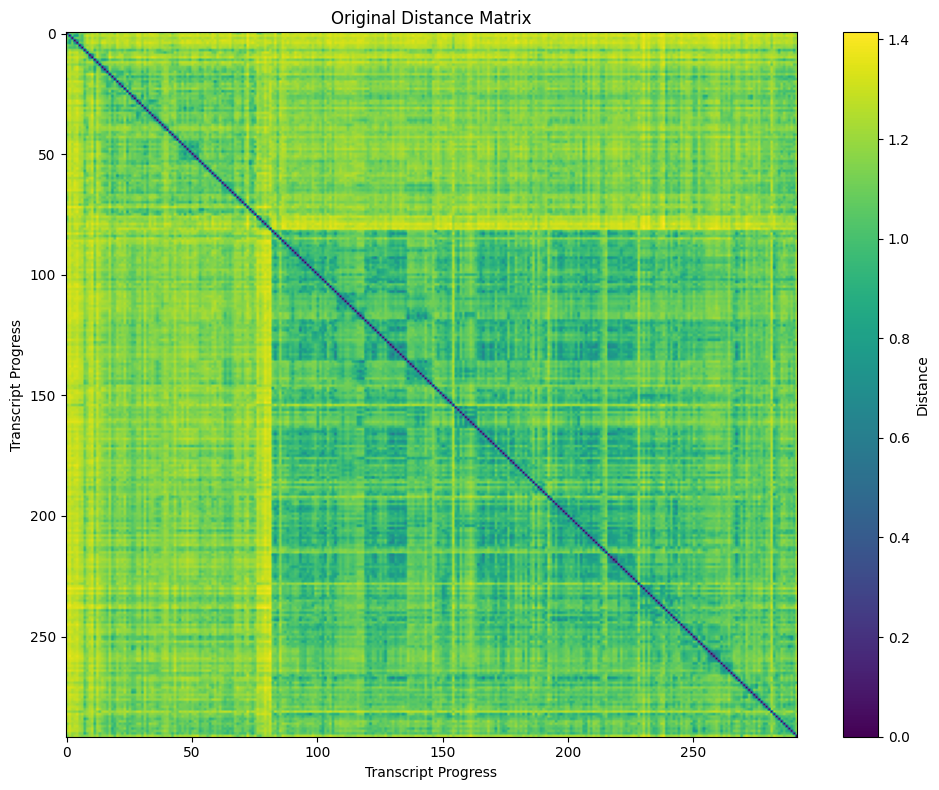

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming 'distances_matrix' is your existing distance matrix
# If not, replace with: distances_matrix = np.random.rand(300, 300)

# 1. Apply K-means clustering
k = 5  # Number of clusters, adjust as needed
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(distances_matrix)

# 2. Calculate mean distances for each vector
mean_distances = np.mean(distances_matrix, axis=1)

# 3. Create the bar plot (maintaining original order)
plt.figure(figsize=(15, 6))
bars = plt.bar(range(len(mean_distances)), mean_distances, width=1.0)

# 4. Color the bars according to their cluster
colors = plt.cm.rainbow(np.linspace(0, 1, k))
for i, bar in enumerate(bars):
    bar.set_color(colors[cluster_labels[i]])

# 5. Customize the plot
plt.xlabel('Transcript Progress')
plt.ylabel('Mean Distance')
plt.title('Clustered Bar Plot of Vector Distances (Preserving Transcript Order)')

# Add a color legend
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(k)]
plt.legend(handles, [f'Cluster {i+1}' for i in range(k)])

# 6. Add vertical lines to separate every 50 bars (adjust as needed)
for i in range(50, len(mean_distances), 50):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Optional: Plot the original distance matrix for comparison
plt.figure(figsize=(10, 8))
plt.imshow(distances_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Distance')
plt.title('Original Distance Matrix')
plt.xlabel('Transcript Progress')
plt.ylabel('Transcript Progress')
plt.tight_layout()
plt.show()

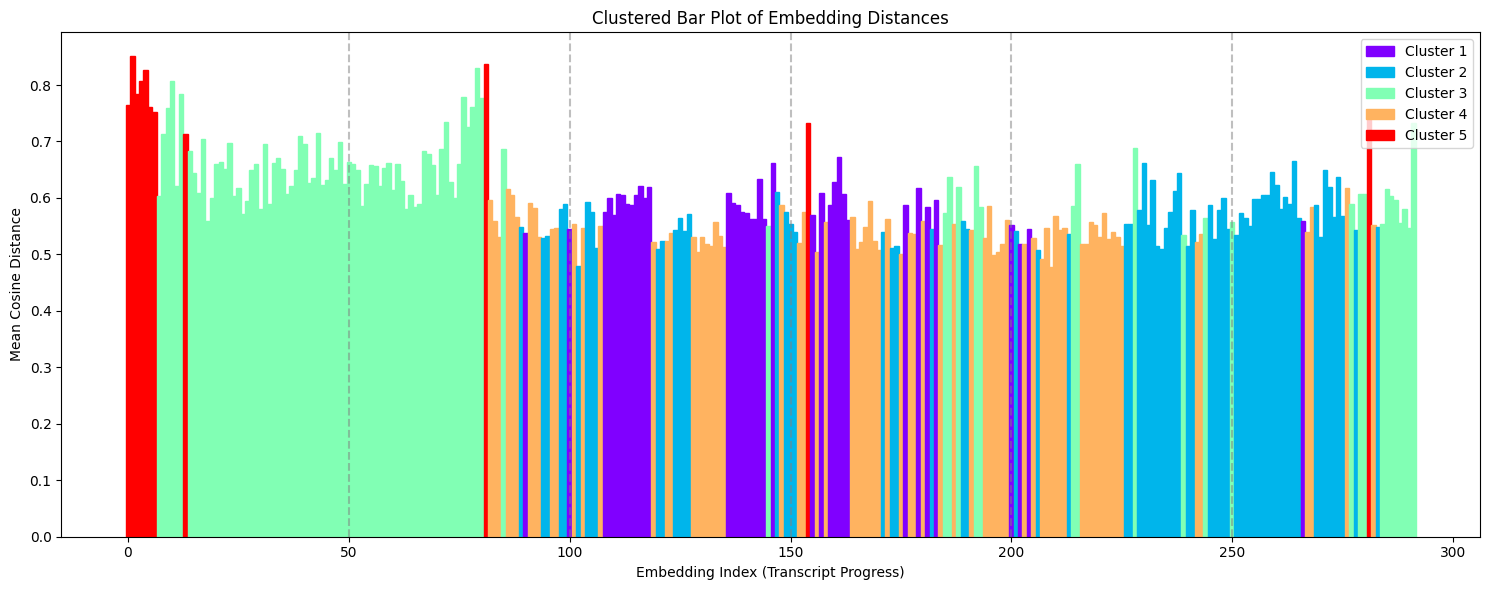

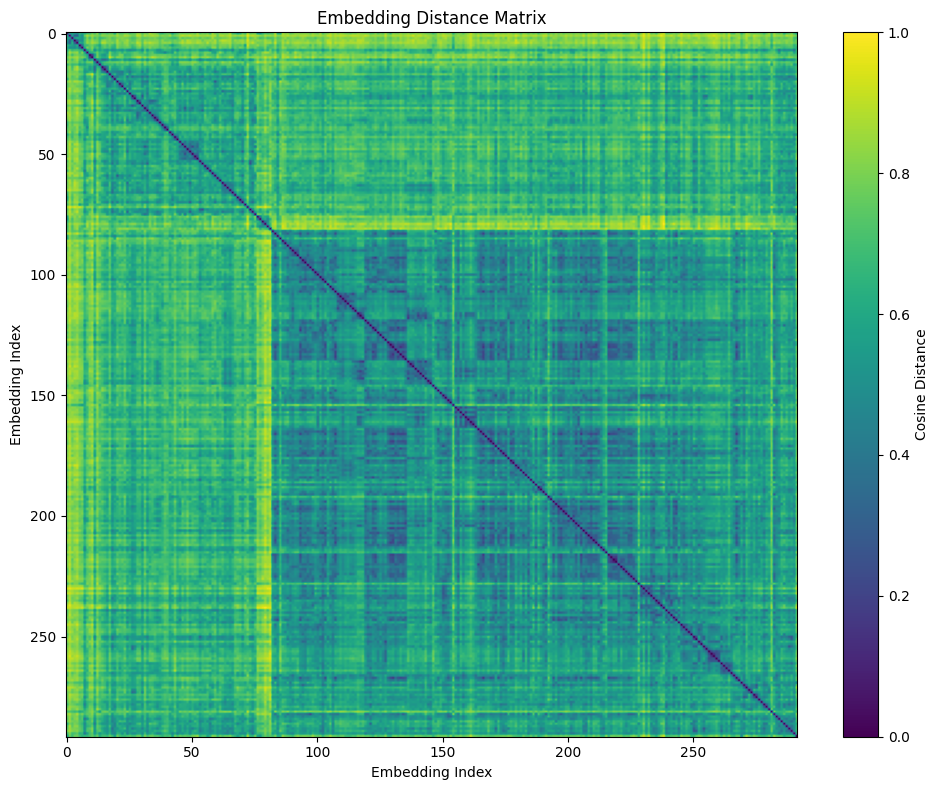

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances

# Assuming all_embeddings is a list of embeddings
# If not, you would define it as: all_embeddings = [...]

# Convert list of embeddings to a numpy array
embeddings_array = np.array(all_embeddings_data)

# 1. Apply K-means clustering
k = 5  # Number of clusters, adjust as needed
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_array)

# 2. Calculate cosine distances between embeddings
distances_matrix = cosine_distances(embeddings_array)

# 3. Calculate mean distances for each embedding
mean_distances = np.mean(distances_matrix, axis=1)

# 4. Create the bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(range(len(mean_distances)), mean_distances, width=1.0)

# 5. Color the bars according to their cluster
colors = plt.cm.rainbow(np.linspace(0, 1, k))
for i, bar in enumerate(bars):
    bar.set_color(colors[cluster_labels[i]])

# 6. Customize the plot
plt.xlabel('Embedding Index (Transcript Progress)')
plt.ylabel('Mean Cosine Distance')
plt.title('Clustered Bar Plot of Embedding Distances')

# Add a color legend
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(k)]
plt.legend(handles, [f'Cluster {i+1}' for i in range(k)])

# 7. Add vertical lines to separate every 50 bars (adjust as needed)
for i in range(50, len(mean_distances), 50):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 8. Plot the distance matrix heatmap
plt.figure(figsize=(10, 8))
plt.imshow(distances_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Cosine Distance')
plt.title('Embedding Distance Matrix')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.tight_layout()
plt.show()

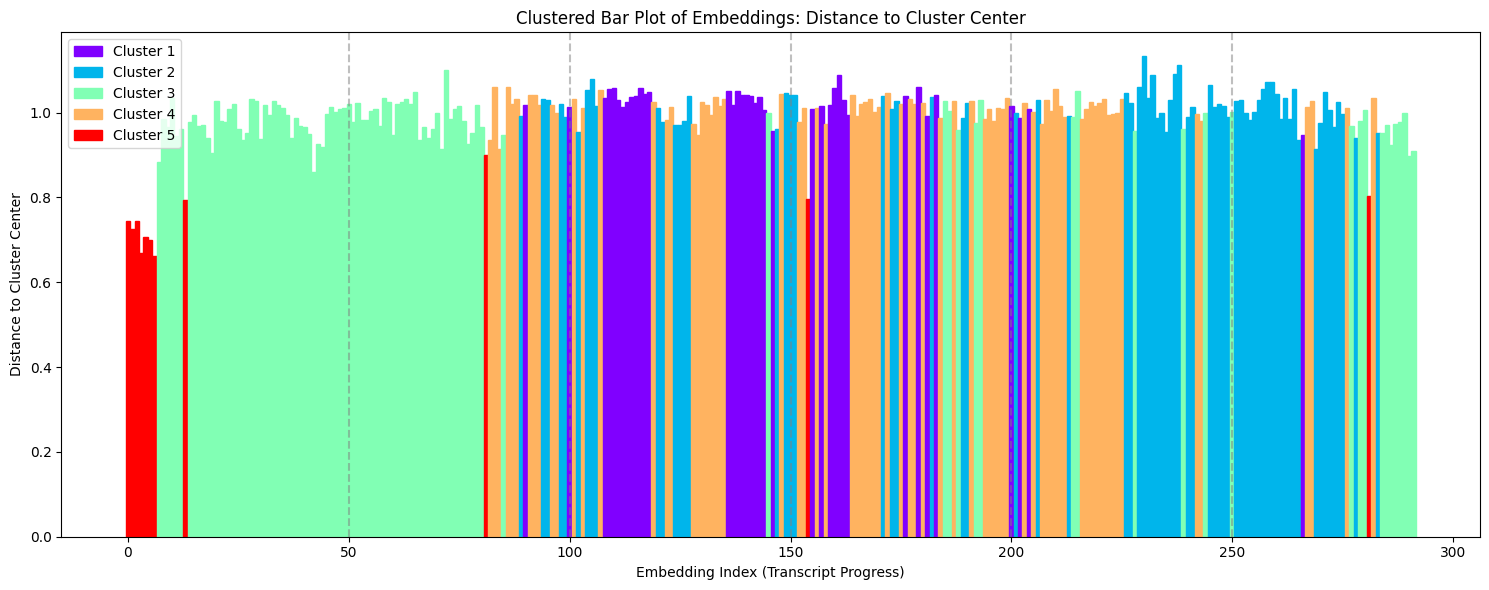

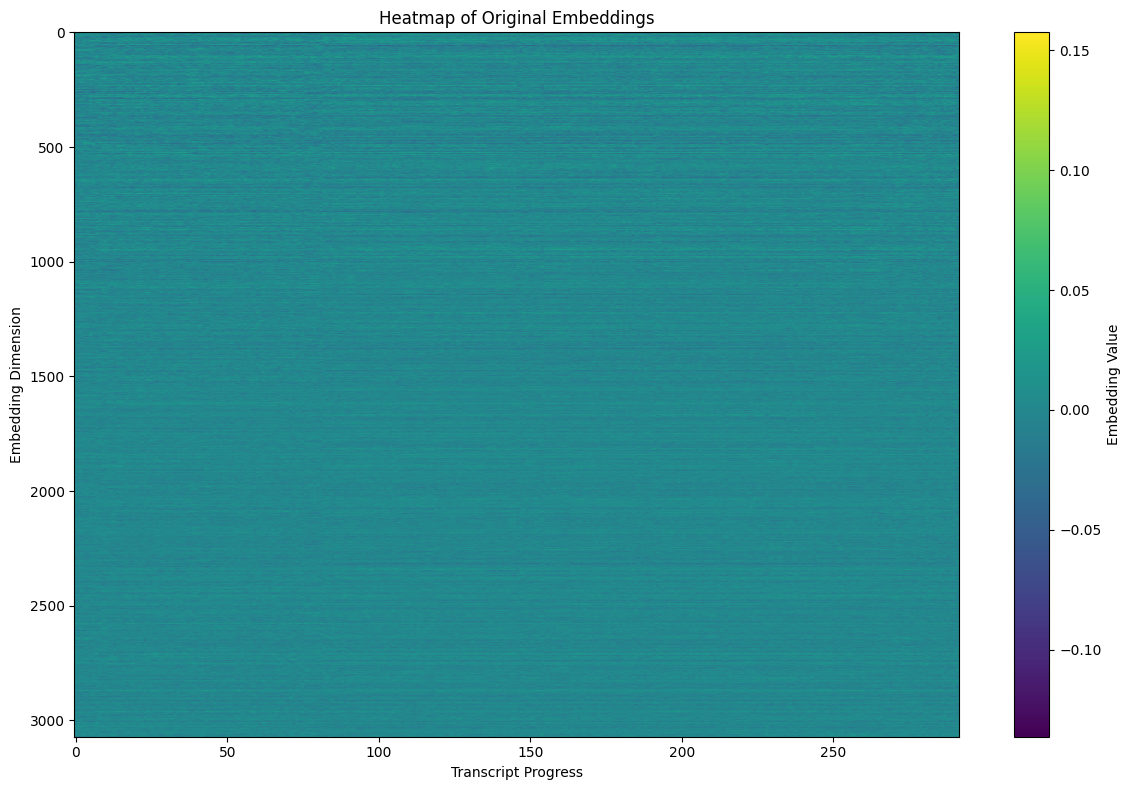

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Assuming all_embeddings is a list of embeddings
# If not, you would define it as: all_embeddings = [...]

# Convert list of embeddings to a numpy array
embeddings_array = np.array(all_embeddings_data)

# 1. Apply K-means clustering
k = 5  # Number of clusters, adjust as needed
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_array)

# 2. Calculate distances from each embedding to its cluster center
distances_to_center = pairwise_distances(embeddings_array, kmeans.cluster_centers_[cluster_labels])
distances_to_center = distances_to_center[np.arange(len(embeddings_array)), 0]

# 3. Create the bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(range(len(distances_to_center)), distances_to_center, width=1.0)

# 4. Color the bars according to their cluster
colors = plt.cm.rainbow(np.linspace(0, 1, k))
for i, bar in enumerate(bars):
    bar.set_color(colors[cluster_labels[i]])

# 5. Customize the plot
plt.xlabel('Embedding Index (Transcript Progress)')
plt.ylabel('Distance to Cluster Center')
plt.title('Clustered Bar Plot of Embeddings: Distance to Cluster Center')

# Add a color legend
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(k)]
plt.legend(handles, [f'Cluster {i+1}' for i in range(k)])

# 6. Add vertical lines to separate every 50 bars (adjust as needed)
for i in range(50, len(distances_to_center), 50):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 7. Plot a heatmap of the original embeddings
plt.figure(figsize=(12, 8))
plt.imshow(embeddings_array.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Embedding Value')
plt.title('Heatmap of Original Embeddings')
plt.xlabel('Transcript Progress')
plt.ylabel('Embedding Dimension')
plt.tight_layout()
plt.show()

In [20]:
kmeans.cluster_centers_

array([[-0.01925581, -0.02125205, -0.02722373, ...,  0.00471672,
         0.00727051, -0.01730071],
       [-0.00391517, -0.02693872, -0.02729835, ..., -0.00285093,
         0.00758957, -0.00882587],
       [-0.01836309, -0.02116797, -0.02373976, ..., -0.00384235,
         0.01002743, -0.00884883],
       [-0.00564178, -0.01880465, -0.02890113, ...,  0.00133665,
         0.00542783, -0.01026063],
       [-0.01745681,  0.01007117, -0.02821446, ..., -0.00683841,
         0.00030236, -0.01850296]])

In [23]:
len(kmeans.cluster_centers_)

5

In [32]:

def value_labels(cluster_labels):
    prev_v=None
    count=0
    for i in range(len(cluster_labels)):
        if prev_v!=cluster_labels[i]:
            count+=1
        prev_v=cluster_labels[i]

    return count


In [41]:
# 2
value_labels(cluster_labels)

43

In [39]:
# 3
value_labels(cluster_labels)

72

In [33]:
# 4
value_labels(cluster_labels)

94

In [35]:
# 5
value_labels(cluster_labels)

91

In [37]:
# 6
value_labels(cluster_labels)

116

In [46]:
# 7
value_labels(cluster_labels)

120

In [44]:
94/3

31.333333333333332

In [47]:
91/(4/2)

45.5

In [48]:
116/(5/2)

46.4

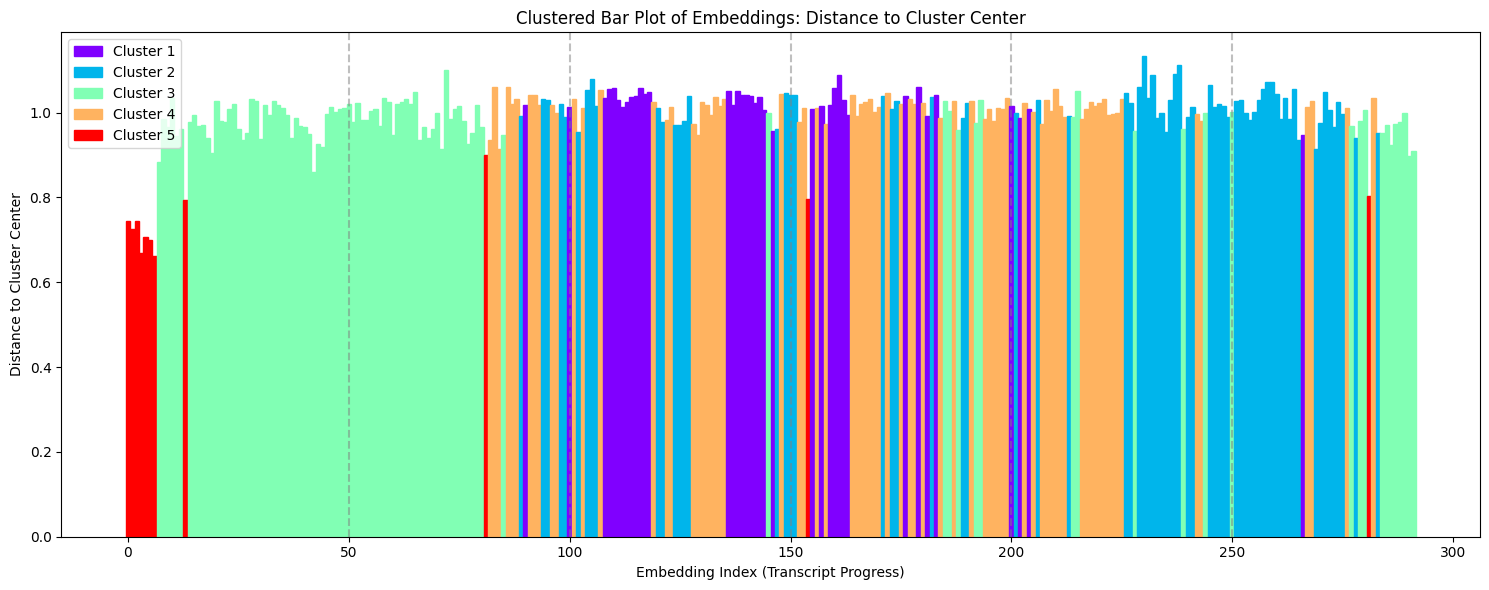

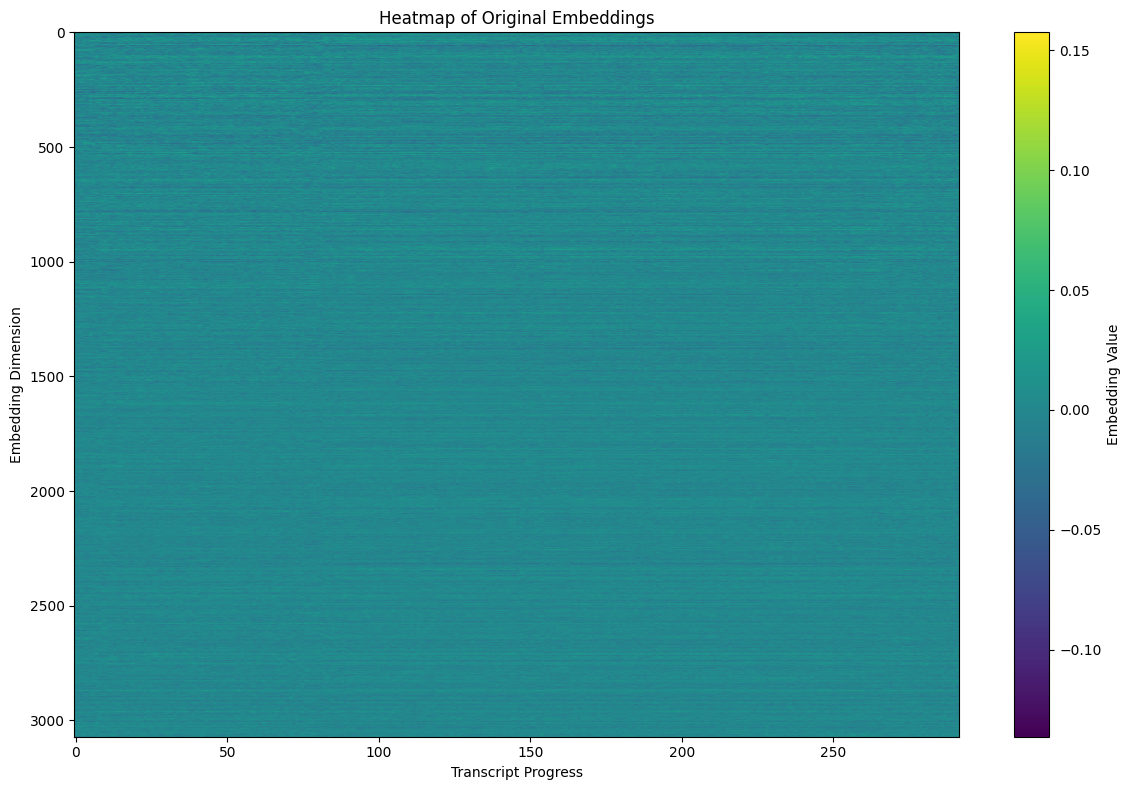

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Assuming all_embeddings is a list of embeddings
# If not, you would define it as: all_embeddings = [...]

# Convert list of embeddings to a numpy array
embeddings_array = np.array(all_embeddings_data)

# 1. Apply K-means clustering
k = 5 # Number of clusters, adjust as needed
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_array)

# kmeans.cluster_centers_[3]=kmeans.cluster_centers_[4]

# 2. Calculate distances from each embedding to its cluster center
distances_to_center = pairwise_distances(embeddings_array, kmeans.cluster_centers_[cluster_labels])
distances_to_center = distances_to_center[np.arange(len(embeddings_array)), 0]

# 3. Create the bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(range(len(distances_to_center)), distances_to_center, width=1.0)

# 4. Color the bars according to their cluster
colors = plt.cm.rainbow(np.linspace(0, 1, k))
for i, bar in enumerate(bars):
    bar.set_color(colors[cluster_labels[i]])

# 5. Customize the plot
plt.xlabel('Embedding Index (Transcript Progress)')
plt.ylabel('Distance to Cluster Center')
plt.title('Clustered Bar Plot of Embeddings: Distance to Cluster Center')

# Add a color legend
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(k)]
plt.legend(handles, [f'Cluster {i+1}' for i in range(k)])

# 6. Add vertical lines to separate every 50 bars (adjust as needed)
for i in range(50, len(distances_to_center), 50):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 7. Plot a heatmap of the original embeddings
plt.figure(figsize=(12, 8))
plt.imshow(embeddings_array.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Embedding Value')
plt.title('Heatmap of Original Embeddings')
plt.xlabel('Transcript Progress')
plt.ylabel('Embedding Dimension')
plt.tight_layout()
plt.show()

# label the content of each cluster label

In [ ]:
fast_recap_data.plot_object["segments"]

In [ ]:
cluster_labels

In [81]:
cluster_text_data=""
for i in range(len(fast_recap_data.plot_object["segments"])):
    seg=fast_recap_data.plot_object["segments"][i]  
    if cluster_labels[i]==0:
        cluster_text_data+=seg["recap"]+"\n"
print(len(cluster_text_data))

14120


In [82]:
system_prompt="""You are to take a bunch of text summaries and pull them together into what the topic dicussed for that is. YOU MUST DESCRIBE IT IN A FEW WORDS AND THEN GIVE MORE CONTEXT BUT YOU ARE DISTILLING TO 1 CATEGORY OF TOPIC."""
user_prompt=cluster_text_data
prompt=[{"role":"system","content":system_prompt},{"role":"user","content":user_prompt}]
cat, tc=await utils.async_response_handler(prompt, utils.ModelNameEnum.gpt_4o_mini)

In [83]:
# 0
print(cat)

**Topic: Presidential Powers and Constitutional Interpretation**

The discussions primarily revolve around the complexities of presidential powers, particularly in relation to criminal immunity, accountability, and the constitutional framework governing these issues. Participants critique the Supreme Court's interpretations, especially regarding originalism and its application to cases like Roe v. Wade and presidential immunity. They explore the balance of power between the executive and legislative branches, questioning the extent of Congress's authority to regulate presidential actions and the implications of judicial decisions on these powers.

Key points include debates on the legitimacy of presidential immunity, the historical context of the 14th Amendment, and the potential for Congress to limit presidential powers, particularly in military and criminal contexts. The discussions also touch on the moral implications of constitutional legality, emphasizing that just because an acti

In [80]:
# 1
print(cat)

**Topic: Supreme Court Nominations and Political Maneuvering**

The discussions primarily revolve around the contentious nature of Supreme Court nominations, particularly focusing on the political tactics employed by both Democrats and Republicans. Participants critique the manipulation of Senate rules and the implications of these actions on the integrity of the judicial system. Key points include the historical context of nominations, such as Merrick Garland's stalled appointment, the impact of the filibuster, and the perceived hypocrisy in the actions of political leaders like Mitch McConnell and Joe Biden.

The conversations highlight the challenges faced by Democrats in securing judicial appointments due to Republican resistance and the strategic maneuvering that has characterized recent nomination processes. There is a strong emphasis on the need for procedural reforms to ensure timely hearings and votes on nominees, as well as the broader implications of these political games on

In [77]:
# 2
print(cat)

**Topic: Political Discourse and Strategy**

The discussions primarily revolve around the complexities of political discourse, strategies, and the impact of various leaders and policies on the current political landscape. Key themes include the competitive nature of politics, the influence of media, election integrity, and the contrasting approaches of different political figures, particularly in the context of recent events and historical precedents.

The speaker critiques the current political climate, expressing frustration over the lack of accountability and the perceived double standards between parties. They emphasize the importance of effective communication and strategic negotiation in politics, highlighting the need for politicians to engage with the public meaningfully. The conversation also touches on the evolving media landscape and its role in shaping political narratives, as well as the challenges faced by politicians transitioning from business to public service.

Additi

In [74]:
# 3
print(cat)

**Topic: Court Packing and Judicial Integrity**

The discussion revolves around the contentious issue of court packing, which refers to the idea of expanding the number of justices on the Supreme Court to influence its ideological balance. Participants express a range of opinions on the implications of this strategy, with many arguing that it threatens the integrity and legitimacy of the judiciary. Critics of court packing assert that it undermines the Constitution and could lead to a politicized court that merely rubber stamps the agendas of the ruling party. They emphasize the importance of maintaining established norms and the potential dangers of retaliatory actions that could further erode public trust in the judicial system.

Supporters of court packing, however, argue that it may be a necessary response to perceived injustices and the obstruction of judicial nominations by the opposing party. They reference historical precedents and the current political landscape, suggesting th

In [71]:
# 4
print(cat)

**Topic: Technology and Media Discussions**

The conversation revolves around various aspects of technology, particularly focusing on graphics cards, audio quality, and the impact of online platforms on media consumption. The speakers delve into specific hardware like Nvidia's A4000 and RTX series, discussing their performance, power consumption, and suitability for tasks like streaming and encoding. They also critique their podcast setup, emphasizing the importance of audio and video quality in live streaming, while comparing their setup to professional standards. Additionally, the discussion touches on the dominance of online platforms, exemplified by Elon Musk's audience reach, and the challenges faced during technical calls, highlighting the evolving landscape of media and technology.


In [58]:
print(len(cluster_text_data))

104152


In [60]:
print(cat)

The discussions cover a wide range of topics primarily focused on political dynamics, judicial integrity, and the implications of various political strategies. Key themes include:

1. **Judicial Appointments and Court Packing**: There is significant debate over the implications of court packing, with participants expressing concerns about its potential to undermine the integrity of the Supreme Court. Discussions also touch on the historical context of judicial nominations, particularly the actions of Mitch McConnell and the implications of the filibuster on judicial appointments.

2. **Political Accountability and Strategy**: The conversations highlight frustrations with perceived Republican impunity and the challenges Democrats face in negotiating with them. Participants express concerns about the lack of accountability for Republicans compared to Democrats, particularly in the context of past crises and current political maneuvers.

3. **Presidential Powers and Actions**: The discuss

# FILTER THE GRAPH

In [90]:
last_3_clusters=[None,None, 1]

max(set(last_3_clusters), key=last_3_clusters.count)

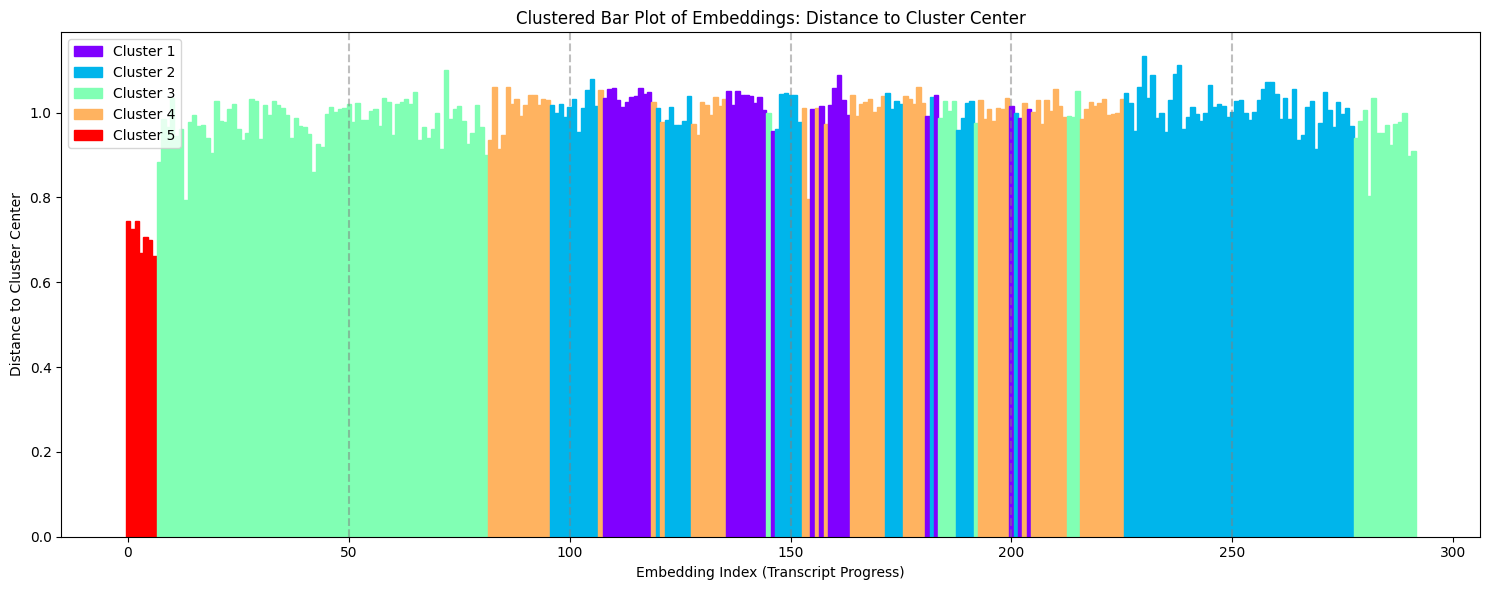

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Assuming all_embeddings is a list of embeddings
# If not, you would define it as: all_embeddings = [...]

# Convert list of embeddings to a numpy array
embeddings_array = np.array(all_embeddings_data)

# 1. Apply K-means clustering
k = 5 # Number of clusters, adjust as needed
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_array)

cluster_labels2=cluster_labels.copy()

filter_window=5
last_x_clusters=[None]*(5-int(filter_window/2))+list(cluster_labels2[:int(filter_window/2)])
# last_x_clusters=[None]*filter_window
for i in range(len(cluster_labels)):
    # get the number in last_3_clusters that dominates, in otherwards get the item with the max quantity
    last_x_clusters.pop(0)
    last_x_clusters.append(cluster_labels[i+int(filter_window/2)] if len(cluster_labels) > (i+int(filter_window/2)) else None)
    max_quantity_item=max(set(last_x_clusters), key=last_x_clusters.count)
    if max_quantity_item:
        cluster_labels2[i]=max_quantity_item

cluster_labels=cluster_labels2






# kmeans.cluster_centers_[3]=kmeans.cluster_centers_[4]

# 2. Calculate distances from each embedding to its cluster center
distances_to_center = pairwise_distances(embeddings_array, kmeans.cluster_centers_[cluster_labels])
distances_to_center = distances_to_center[np.arange(len(embeddings_array)), 0]

# 3. Create the bar plot
plt.figure(figsize=(15, 6))
bars = plt.bar(range(len(distances_to_center)), distances_to_center, width=1.0)

# 4. Color the bars according to their cluster
colors = plt.cm.rainbow(np.linspace(0, 1, k))
for i, bar in enumerate(bars):
    bar.set_color(colors[cluster_labels[i]])

# 5. Customize the plot
plt.xlabel('Embedding Index (Transcript Progress)')
plt.ylabel('Distance to Cluster Center')
plt.title('Clustered Bar Plot of Embeddings: Distance to Cluster Center')

# Add a color legend
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(k)]
plt.legend(handles, [f'Cluster {i+1}' for i in range(k)])

# 6. Add vertical lines to separate every 50 bars (adjust as needed)
for i in range(50, len(distances_to_center), 50):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [95]:
tl[3] if len(tl) > 3 else None


AttributeError: 'list' object has no attribute 'get'